## Parameter optimization for t-SNE

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels

%aimport models.cluster
from models.cluster import get_clustering_performance
%aimport models.dimensionality_reduction
from models.dimensionality_reduction.TSNEModel import TSNEModel
from models.dimensionality_reduction.BayesianTSNEOptimizer import BayesianTSNEOptimizer

Load data from disk.

In [2]:
# Load data from disk.
data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")
dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

Calculate distances.

In [3]:
trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_total(dfs)
euclidean_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="euclidean")

Prepare distance data for fitting of t-SNE model.

In [5]:
categorical_columns = ["mode", "notes", "scripted", "token", "trip_id"]
segment_distance_matrix = euclidean_distances.drop(categorical_columns,axis=1)

Next steps: Integrate BayesianTSNEOptimizer, start optimization (record results and ingest at next start as initialization values).

In [7]:
# Define parameter ranges, fix static variables.
param_ranges = deepcopy(TSNEModel.PARAMETER_RANGES)
param_ranges["metric"] = (TSNEModel.CATEGORICAL_VALUES["metric"].index("precomputed"),)
param_ranges["init_method"] = (TSNEModel.CATEGORICAL_VALUES["init_method"].index("random"),)
param_ranges["random_state"] = (42,)

# Initialize new BO object.
boOpt = BayesianTSNEOptimizer(high_dim_data=segment_distance_matrix, parameters=param_ranges)

# Load existing results.
history = BayesianTSNEOptimizer.load_result_dict("tsne_results")
print("Number of models generated so far: ", len(history["values"]))

# Execute optimization; initialize with existing results.
# Use higher init_fraction if not many initialization datapoints are available.
results = boOpt.run(num_iterations=5, init_fraction=0.05, init_values=history, kappa=4.0)
# Save merged result set (new results and existing ones).
all_results = BayesianTSNEOptimizer.merge_result_dictionaries(results, history)
BayesianTSNEOptimizer.persist_result_dict(
    results=all_results,
    filename="tsne_results"
)

Number of models generated so far:  121
Initialization
------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     angle |   early_exaggeration |   learning_rate |   min_grad_norm |   n_components |    n_iter |   perplexity | 
    1 | 00m39s |    0.58739 |    0.2073 |              47.6315 |        149.4988 |          0.0636 |         2.3869 | 7509.5084 |      72.2963 | 
    2 | 00m00s |    0.43367 |    0.1000 |               1.0000 |       2000.0000 |          0.1000 |         3.0000 | 9323.0799 |     100.0000 | 
    3 | 00m00s |    0.35483 |    1.0000 |              50.0000 |        580.4813 |          0.0064 |         3.0000 | 5789.4868 |       1.0000 | 
    4 | 00m00s |    0.46432 |    0.9866 |               1.0000 |        467.3309 |          0.0957 |         2.5793 | 9035.0941 |       1.0000 | 
    5 | 00m00s |    0.35189 |    1.0000 |              50.0000 |      

Bayesian Optimization
------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     angle |   early_exaggeration |   learning_rate |   min_grad_norm |   n_components |    n_iter |   perplexity | 
  123 | 01m18s |    0.56666 |    0.7751 |              40.5631 |        400.4047 |          0.0978 |         2.3270 | 8088.8215 |      97.4643 | 
  124 | 01m04s |    0.54395 |    0.6801 |              27.6359 |       1999.9442 |          0.0965 |         1.7108 | 4880.8415 |      95.8059 | 
  125 | 01m03s |    0.55892 |    0.8138 |              46.0018 |       1051.7925 |          0.0890 |         1.8136 | 2128.7933 |      99.5615 | 
  126 | 00m57s |    0.53214 |    0.9467 |               1.0000 |        411.9286 |          0.0941 |         3.0000 | 7409.3501 |     100.0000 | 


Sort results by score, pick highest.

In [117]:
all_results_sorted_idx = np.argsort(all_results["values"])
max_score_index = all_results_sorted_idx[-15]
best_param_set = all_results["params"][max_score_index]
print(best_param_set)

{'learning_rate': 179.5116571591052, 'n_iter': 532.1184828088094, 'min_grad_norm': 0.044908797348463279, 'angle': 0.90195690323605737, 'perplexity': 99.691711730640023, 'early_exaggeration': 47.904839577449316, 'n_components': 1.2600238078881951}


(Re-)Generate model with given parameter set, since we didn't store the results for each run.

In [118]:
tsne = TSNEModel(num_dimensions=int(round(best_param_set["n_components"])),
                 perplexity=best_param_set["perplexity"],
                 early_exaggeration=best_param_set["early_exaggeration"],
                 learning_rate=best_param_set["learning_rate"],
                 num_iterations=int(round(best_param_set["n_iter"])),
                 min_grad_norm=best_param_set["min_grad_norm"],
                 random_state=42,
                 angle=best_param_set["angle"],
                 metric='precomputed',
                 init_method='random')
# Fit t-SNE model.
tsne_results = tsne.run(segment_distance_matrix.values)
quality_measures = tsne.calculate_quality_measures(segment_distance_matrix.values)

KeyboardInterrupt: 

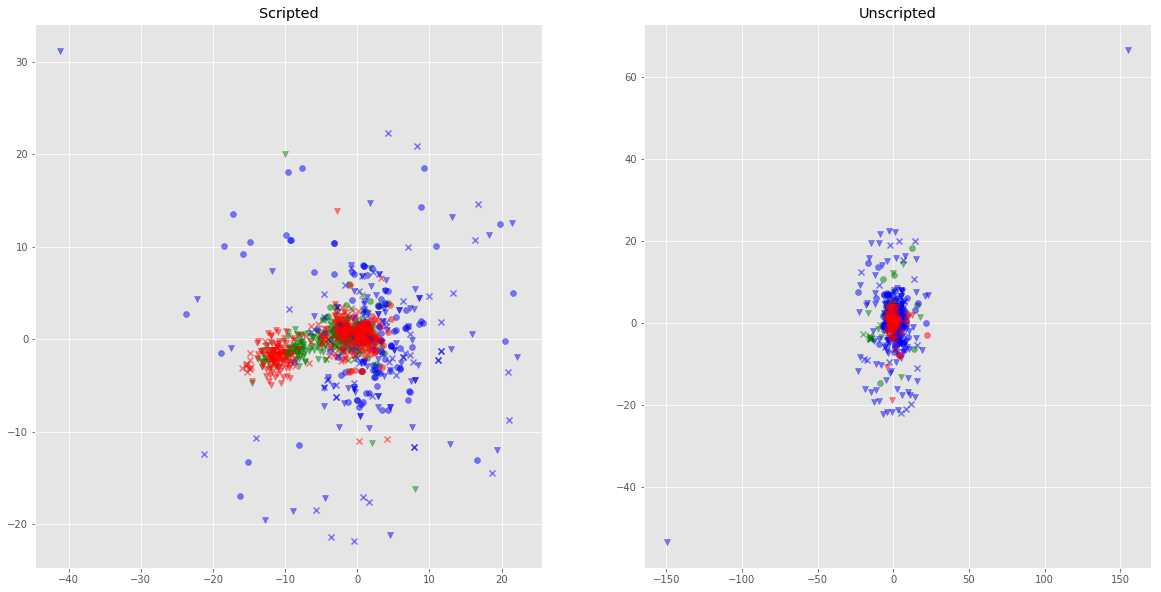

In [114]:
transport_modes = {
    'WALK': 'blue',
    'METRO': 'red',
    'TRAM': 'green'
}
tokens = {
    '355007075245007': 'x',
    '358568053229914': 'o',
    '868049020858898': 'v'
}


fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for transport_mode, transport_mode_color in transport_modes.items():
    transport_mode_scripted = euclidean_distances[
        (euclidean_distances["mode"] == transport_mode) &
        (euclidean_distances["notes"].str.contains('scripted'))
    ]
    transport_mode_unscripted = euclidean_distances[
        (euclidean_distances["mode"] == transport_mode) &
        (~(euclidean_distances["notes"].str.contains('scripted', na=False)))
    ]
    
    for token, token_symbol in tokens.items():
        transport_mode_scripted_for_token = transport_mode_scripted[
            transport_mode_scripted["token"] == token
        ].index.values
        transport_mode_unscripted_for_token = transport_mode_unscripted[
            transport_mode_unscripted["token"] == token
        ].index.values
        
        ax[0].scatter(
            tsne_results[transport_mode_scripted_for_token, 0], 
            tsne_results[transport_mode_scripted_for_token, 1], 
            c=transport_mode_color, 
            marker=token_symbol, 
            alpha=0.5
        )
        ax[1].scatter(
            tsne_results[transport_mode_unscripted_for_token, 0], 
            tsne_results[transport_mode_unscripted_for_token, 1], 
            c=transport_mode_color, 
            marker=token_symbol, 
            alpha=0.5
        )

ax[0].set_title('Scripted')
ax[1].set_title('Unscripted')
ax[0].legend(loc='upper center', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='upper center', bbox_to_anchor=(1, 0.5))